In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import pandas as pd
import warnings
import pickle

%matplotlib inline
from IPython.display import clear_output

import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.utils.prune as prune

from missforest.missforest import MissForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing(as_frame=True)
data = california_housing.frame

In [3]:
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [ ]:
X = data.drop('MedHouseVal', axis=1)
Y = data['MedHouseVal']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [13]:
X_scaled

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,2.344766,0.982143,0.628559,-0.153758,-0.974429,-0.049597,1.052548,-1.327835
1,2.332238,-0.607019,0.327041,-0.263336,0.861439,-0.092512,1.043185,-1.322844
2,1.782699,1.856182,1.155620,-0.049016,-0.820777,-0.025843,1.038503,-1.332827
3,0.932968,1.856182,0.156966,-0.049833,-0.766028,-0.050329,1.038503,-1.337818
4,-0.012881,1.856182,0.344711,-0.032906,-0.759847,-0.085616,1.038503,-1.337818
...,...,...,...,...,...,...,...,...
20635,-1.216128,-0.289187,-0.155023,0.077354,-0.512592,-0.049110,1.801647,-0.758826
20636,-0.691593,-0.845393,0.276881,0.462365,-0.944405,0.005021,1.806329,-0.818722
20637,-1.142593,-0.924851,-0.090318,0.049414,-0.369537,-0.071735,1.778237,-0.823713
20638,-1.054583,-0.845393,-0.040211,0.158778,-0.604429,-0.091225,1.778237,-0.873626


In [101]:
v = X_scaled['MedInc'].to_numpy()
np.mean(np.exp(v) / (np.exp(v) + 0.35))

u = X_scaled['Population'].to_numpy()
np.mean(1 / (0.4*np.exp(u) + 1))

np.float64(0.7041549794738552)

In [102]:
Omega = np.random.binomial(1, 0.7, (20640, 8))
for i in range(20640):
    income = X_scaled['MedInc'][i]
    prob = np.exp(income) / (np.exp(income) + 0.35)
    Omega[i, 0] = np.random.binomial(1, prob, 1)[0]

    population = X_scaled['Population'][i]
    prob = 1 / (0.4*np.exp(population) + 1)
    Omega[i, 4] = np.random.binomial(1, prob, 1)[0]

Z = X.copy(deep=True)
Z = Z.mask(Omega==0)
scaler = StandardScaler()
Z = pd.DataFrame(scaler.fit_transform(Z), columns=Z.columns)
Z_ZI = Z.fillna(0)

In [103]:
Z_train, Z_test, Z_ZI_train, Z_ZI_test, Omega_train, Omega_test, Y_train, Y_test = train_test_split(Z, Z_ZI, Omega, Y, test_size=0.2)
Z_train, Z_val, Z_ZI_train, Z_ZI_val, Omega_train, Omega_val, Y_train, Y_val = train_test_split(Z_train, Z_ZI_train, Omega_train, Y_train, test_size=0.125)

Z_ZI_train = torch.tensor(Z_ZI_train.to_numpy(), dtype=torch.float32)
Z_ZI_val = torch.tensor(Z_ZI_val.to_numpy(), dtype=torch.float32)
Z_ZI_test = torch.tensor(Z_ZI_test.to_numpy(), dtype=torch.float32)

Omega_train = torch.tensor(Omega_train, dtype=torch.float32)
Omega_val = torch.tensor(Omega_val, dtype=torch.float32)
Omega_test = torch.tensor(Omega_test, dtype=torch.float32)
Y_train = torch.tensor(Y_train.to_numpy().reshape(-1,1), dtype=torch.float32)
Y_val = torch.tensor(Y_val.to_numpy().reshape(-1,1), dtype=torch.float32)
Y_test = torch.tensor(Y_test.to_numpy().reshape(-1,1), dtype=torch.float32)

In [104]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001, restore_best_weights=True):
        """
        Args:
            patience (int): How many epochs to wait after last improvement
            min_delta (float): Minimum change to qualify as an improvement
            restore_best_weights (bool): Whether to restore model weights from the best epoch
        """
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_score = None
        self.best_weights = None
        self.counter = 0
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        score = -val_loss  # We use negative because greater score = better performance
        
        if self.best_score is None:
            self.best_score = score
            if self.restore_best_weights:
                self.best_weights = self._get_weights(model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            if self.restore_best_weights:
                self.best_weights = self._get_weights(model)
            self.counter = 0
            
    def _get_weights(self, model):
        return {name: param.clone().detach() for name, param in model.state_dict().items()}
    
    def restore_weights(self, model):
        if self.restore_best_weights and self.best_weights is not None:
            model.load_state_dict(self.best_weights)

In [105]:
def global_prune(model, amount):
    # Collect all Linear layers and their weights
    parameters_to_prune = [
        (module, 'weight') 
        for module in model.modules()
        if isinstance(module, nn.Linear)
    ]

    # Perform global L1 unstructured pruning
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )

    # Process each pruned layer
    for module, param_name in parameters_to_prune:
        # Extract and store mask as buffer
        mask = getattr(module, f"{param_name}_mask").clone()
        module.register_buffer("pruning_mask", mask)
        
        # Reinitialize unpruned weights while preserving zeros
        with torch.no_grad():
            # Get current weights (already pruned)
            weight = getattr(module, param_name)
            
            # Create new initialization
            new_weights = torch.empty_like(weight)
            nn.init.kaiming_uniform_(new_weights, mode='fan_in', nonlinearity='relu')
            
            # Apply mask and update weights
            weight.data.copy_(new_weights * mask)

        # Remove PyTorch's pruning buffers
        prune.remove(module, param_name)

    # Register forward pre-hook to maintain pruning
    def apply_mask(module, inputs):
        if hasattr(module, "pruning_mask"):
            mask = module.pruning_mask
            with torch.no_grad():
                module.weight.data.mul_(mask)  # In-place multiplication

    # Add hooks to all pruned modules
    for module, _ in parameters_to_prune:
        if hasattr(module, "pruning_mask"):
            module.register_forward_pre_hook(apply_mask)

    return model

In [106]:
# Define the class of Pattern Embedding Neural Networks (PENN)
class PENN(nn.Module):
    def __init__(self):
        super().__init__()
        inputdim = 8
        width1 = width3 = 70
        width2 = 30
        embedding_dim = 3
        
        # Construct the neural network f1
        self.f1 = nn.Sequential(
            nn.Linear(inputdim, width1),  
            nn.ReLU(),
            nn.Linear(width1, width1), 
            nn.ReLU(),
            nn.Linear(width1, width1), 
            nn.ReLU()
        )

        # Construct the neural network f2, i.e. the embedding function
        self.f2 = nn.Sequential(
            nn.Linear(inputdim, width2),  
            nn.ReLU(),
            nn.Linear(width2, width2),  
            nn.ReLU(),
            nn.Linear(width2, embedding_dim)
        )

        
        # Construct the neural network f3
        self.f3 = nn.Sequential(
            nn.Linear(width1 + embedding_dim, width3),
            nn.ReLU(),
            nn.Linear(width3, width3),
            nn.ReLU(),
            nn.Linear(width3, width3),
            nn.ReLU(),
            nn.Linear(width3, 1)  
        )
    
    # Combine f1, f2 and f3 to construct the Pattern Embedding Neural Network
    def forward(self, z, omega):
        # Compute the output of f1 and f2
        f1_output = self.f1(z)
        f2_output = self.f2(omega)
        
        # Concatenate the output of f1 and f2
        combined_features = torch.cat((f1_output, f2_output), dim=1)
        
        # Apply the combined network
        final_output = self.f3(combined_features)
        
        return final_output

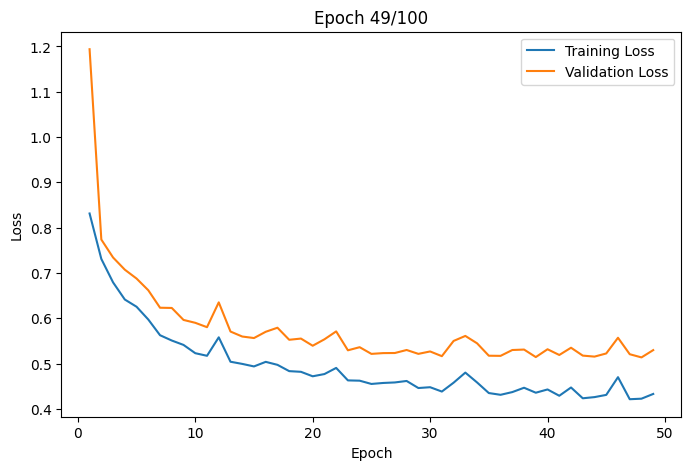

Early stopping triggered at epoch 49.
MSE: 0.49297019839286804
MSE: 0.5142073631286621
R2: 0.632000207901001


In [107]:
lr = 0.001
epochs = 100
patience = 100
weight_decay = 0.001

model_PENN = PENN()
PENN_train_data = TensorDataset(Z_ZI_train, Omega_train, Y_train)
PENN_train_loader = DataLoader(dataset = PENN_train_data, batch_size=200, shuffle=True)

optimizer = optim.Adam(model_PENN.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
early_stopping = EarlyStopping(patience=10, min_delta=0.001)

train_losses = []
val_losses = []

for epoch in range(epochs):

    model_PENN.train()
    if epoch == 10:
        model_PENN = global_prune(model_PENN, amount = 0.6)
    for z_batch, omega_batch, y_batch in PENN_train_loader:
        optimizer.zero_grad()
        pred = model_PENN(z_batch, omega_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        
    # Record training and validation losses
    model_PENN.eval()
    with torch.no_grad():
        train_losses.append(loss_fn(model_PENN(Z_ZI_train, Omega_train), Y_train))
        val_losses.append(loss_fn(model_PENN(Z_ZI_val, Omega_val), Y_val))

    # Live plotting (Jupyter only)
    clear_output(wait=True)  
    plt.figure(figsize=(8, 5))
    plt.plot(range(1,epoch+2), train_losses, label='Training Loss')
    plt.plot(range(1,epoch+2), val_losses, label='Validation Loss')
    plt.title(f'Epoch {epoch+1}/{epochs}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    if epoch >= 10:
        early_stopping(val_losses[-1], model_PENN)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break
 
 
early_stopping.restore_weights(model_PENN)

model_PENN.eval()
print(f'MSE: {loss_fn(model_PENN(Z_ZI_test, Omega_test), Y_test)}')
print(f'MSE: {loss_fn(model_PENN(Z_ZI_val, Omega_val), Y_val)}')
print(f'R2: {1 - loss_fn(model_PENN(Z_ZI_test, Omega_test), Y_test) / Y_test.var(unbiased=False)}')

In [108]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        inputdim = 8
        width = 60

        self.nn = nn.Sequential(
            nn.Linear(inputdim, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width,1)
        )
    
    def forward(self, x):
        final_output = self.nn(x)
        return final_output

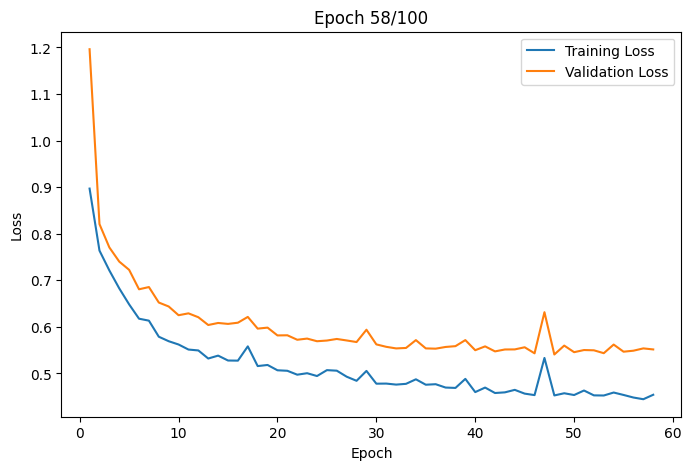

Early stopping triggered at epoch 58.
MSE: 0.5149292349815369
R2: 0.6156079173088074


In [109]:
lr = 0.001
epochs = 100
patience = 100
weight_decay = 0.001

model_NN = NN()
NN_train_data = TensorDataset(Z_ZI_train, Y_train)
NN_train_loader = DataLoader(dataset = NN_train_data, batch_size=200, shuffle=True)

optimizer = optim.Adam(model_NN.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
early_stopping = EarlyStopping(patience=10, min_delta=0.001)

train_losses = []
val_losses = []

for epoch in range(epochs):

    model_NN.train()
    if epoch == 10:
        model_NN = global_prune(model_NN, amount = 0.6)
    for z_batch, y_batch in NN_train_loader:
        optimizer.zero_grad()
        pred = model_NN(z_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        
    # Record training and validation losses
    model_NN.eval()
    with torch.no_grad():
        train_losses.append(loss_fn(model_NN(Z_ZI_train), Y_train))
        val_losses.append(loss_fn(model_NN(Z_ZI_val), Y_val))

    # Live plotting (Jupyter only)
    clear_output(wait=True)  
    plt.figure(figsize=(8, 5))
    plt.plot(range(1,epoch+2), train_losses, label='Training Loss')
    plt.plot(range(1,epoch+2), val_losses, label='Validation Loss')
    plt.title(f'Epoch {epoch+1}/{epochs}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    early_stopping(val_losses[-1], model_NN)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break


early_stopping.restore_weights(model_NN) 

model_NN.eval()
print(f'MSE: {loss_fn(model_NN(Z_ZI_test), Y_test)}')
print(f'R2: {1 - loss_fn(model_NN(Z_ZI_test), Y_test) / Y_test.var(unbiased=False)}')

In [110]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor(
    n_estimators=100,
    n_jobs=-1,
    missing=np.nan
)
model_xgb.fit(Z_ZI_train, Y_train.numpy())
pred_y = model_xgb.predict(Z_ZI_test)
print(np.mean((pred_y - Y_test.numpy().reshape(-1))**2))
print(1 - np.mean((pred_y - Y_test.numpy().reshape(-1))**2) / Y_test.var(unbiased=False))

0.42262846
tensor(0.6845)
